Claudio Sartori©

# Machine Learning - Lab
## Example of Lab exam
### Find the best clustering with __DBSCAN__
# Tasks
Find the clusters in the included dataset.

The solution must be produced as a Python Notebook. The notebook must include appropriate comments and must produce:

1. the boxplots of the attributes and a comment on remarkable situations, if any (2pt)
1. a pairplot of the data (see Seaborn pairplot) and a comment on remarkable situations, if any (2pt)
1. a clustering schema using a method of your choice exploring a range of parameter values (5pt)
1. the plot of the global inertia (SSD) and silhouette index for the parameter values you examine  (4pt)
1. the optimal parameters of your choice (4pt)
1. a pairplot of the data using as hue the cluster assignment with the optimal parameter (3pt)
1. a plot of the silhouette index for the data points, grouped according to the clusters (4pt)
1. A sorted list of the discovered clusters for decreasing sizes (7pt)

NB: this solution is much more than what was requested for the exam

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

# the .py files with the functions provided must be in the same directory of the .ipynb file
from plot_clusters import plot_clusters      # python script provided separately
from plot_silhouette import plot_silhouette  # python script provided separately

In [2]:
data_file = 'lab_exercise.csv'
delimiter = ','
X = np.loadtxt(data_file, delimiter = delimiter)
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

In [3]:
X.shape

(1500, 4)

In order to exploit the Pandas DataFrame features we generate `df` from `X`

<AxesSubplot:>

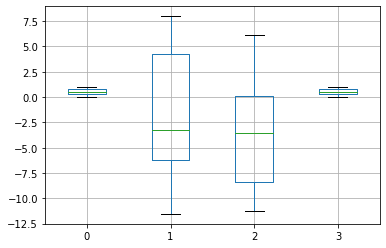

In [4]:
df = pd.DataFrame(X)
df.boxplot()

## 1. Comment on boxplots
Columns 0 and 3 have a range much smaller than 1 and 2. The distributions onf 0 and 3 seem to be equal. Possibly, a min-max rescaling could point out some additional insight.

Let's look at the pairplots and consider if it is worth to do this transformation.

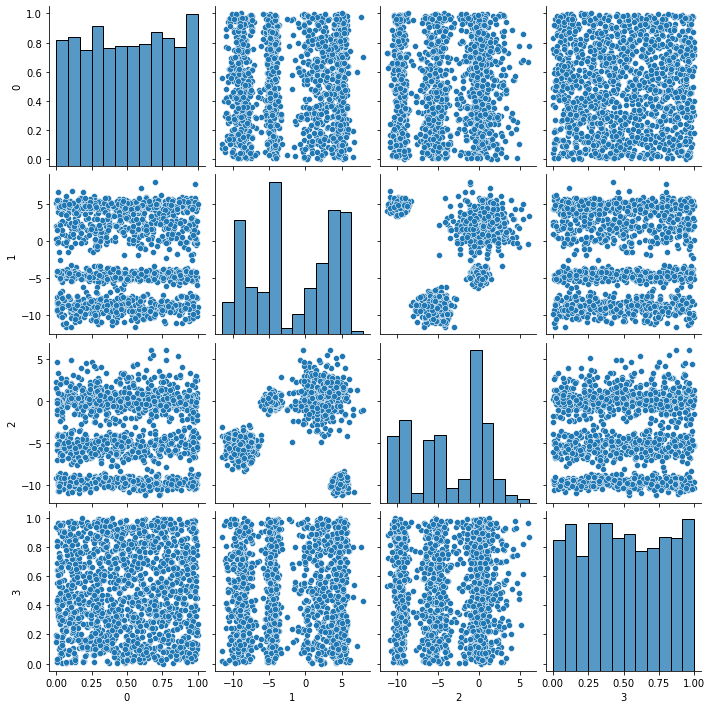

In [5]:
sns.pairplot(pd.DataFrame(X))

## 2. Comments on pairplots
The pairplots show that the two most interesting columns are `1` and `2`, their pairplot shows evident clusters.

The pairplots of `0` and `3` show that those columns are uniformly distributed and do not show any pattern.

In [6]:
int_cols = [1,2] # Interesting columns

## 3. Find a clustering scheme with DBSCAN
We will try DBSCAN with variable parameters using a `ParameterGrid`.

Fit a DBSCAN estimator with the default parameters and examine the results.

In [7]:
db = DBSCAN()
y_db = db.fit_predict(X)

In [8]:
print(db)

DBSCAN()


In [9]:
# Extract the unique labels
cluster_labels_all = np.unique(y_db)
# Exclude -1 (the label of noise) from the unique labels
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
# If there is noise the label -1 will be the first one, 
#    according to the documentation
if cluster_labels_all[0] == -1:
    noise = True
    print("There is noise")
else:
    noise = False
print("There is/are {} cluster(s)".format(n_clusters-noise))

There is noise
There is/are 21 cluster(s)


Plot the clusters and their centers according to the clustering schema obtained with the default parameters. Plot only the dimensions which have been considered interesting.

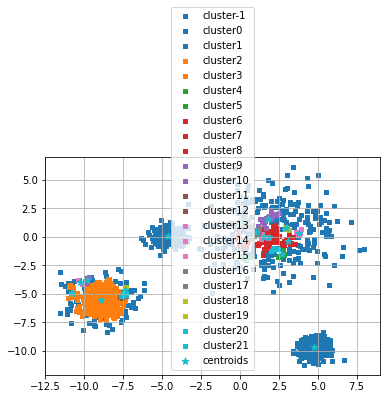

In [10]:
# Prepare a data structure for the centroids
# the number of components is extracted from the shape of X
cluster_centers = np.empty((n_clusters,X.shape[1]))

# for each cluster label filter the data and compute the centroids
# as the mean along each component
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X[y_db==i,:], axis = 0)

# plot the clusters and the centroids
plot_clusters(X,y_db,dim=(int_cols[0],int_cols[1]), points = cluster_centers)

### Find the best parameters using `ParameterGrid`

In [11]:
# prepare the parameters grid for `eps` and `min_samples`
# the ranges will include the default values
param_grid = {'eps': list(np.arange(0.1, 2, 0.1)), # 20 values
              'min_samples': list(range(3,10,1)) # 7 values
             }
params = list(ParameterGrid(param_grid))

# In order to avoid output cluttering, we will set thresholds for 
# the silhouette and the percentage of clustered data
# Combinations under the threshold will not be printed
sil_thr = 0.7  # visualize results only for combinations 
               # with silhouette above the threshold
clust_thr = 0.5 # visualize results only for combinations 
                # with ratio clustered/data above the threshold

In [12]:
def inertia_and_centers(X, y):
    ''' Computes the centroids and the inertia given a set of points X and labels y
        Parameters:
        X   : an array of shape[0] points in shape[1] dimensions
        y   : a vector of labels corresponding to the points, proper labels
              are in range 0..(shape[0]-1); possibly noise points are labelled -1
        Uses the 'Einstein summation convention' from numpy for fast computation of 
        the inertia, see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html#numpy.einsum)
    '''
    cluster_labels_all = np.unique(y)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    cluster_centers = np.empty((n_clusters,X.shape[1]))
    inertia = 0
    for i in cluster_labels:
        X_i = X[y==i,:]
        cluster_centers[i,:] = np.mean(X_i, axis = 0)
        X_i -= cluster_centers[i,:]
        inertia += np.einsum('ij,ij',X_i,X_i).mean()
    return inertia, cluster_centers, n_clusters    

In [13]:
# Prepare a row to describe formatted output
print("{:>11}\t{:>11}\t{:>11}\t{:>11}\t{:>11}\t{:>11}\t{:>11}".\
      format('eps','min_samp','n_clust','silh', 'clust_f', 'sc_index', 'inertia'))
# Prepare a dataframe for the results
results = pd.DataFrame(columns=['eps','min_samp',
                                'n_clust','silh', 'clust_f', 'sc_index', 'inertia'])    
# for each combination of parameter values executes clustering
# then, saves the output if the quality measures are above the thresholds
for i in range(len(params)):
    # initialise, then fit_predict the estimator, obtaining
    # the labelling; unclustered points (noise) are labelled -1
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)
    # list of the proper cluster labels (excluding noise)
#     cluster_labels_all = np.unique(y_db)
#     cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    inertia, cluster_centers, n_clusters = inertia_and_centers(X,y_db)
#     n_clusters = len(cluster_labels)
    # filters out the unclustered points
    X_cl = X[y_db!=-1,:]
    y_db_cl = y_db[y_db!=-1]
    if n_clusters > 1 and n_clusters < X.shape[0]:
        # silhouette index cannot be computed out of this range
        silhouette = silhouette_score(X_cl,y_db_cl)
    else:
        # 0 or N clusters
        silhouette = -2
    clust = y_db_cl.shape[0]/y_db.shape[0] # fraction of clustered
    # sc_index = an index computed as the harmonic mean between 
    # Silhouette and the fraction of clustered 
    # (it is just a suggestion, it is not a standard measure, and
    #  it was not requested for the exercise)
    sc_index = silhouette*clust/(silhouette+clust)
    if silhouette > sil_thr and clust > clust_thr:
        # if above threshold save the results
        results = results.append({'eps':db.eps,
                                  'min_samp':db.min_samples,
                                  'n_clust':n_clusters,
                                  'silh':silhouette, 
                                  'clust_f':clust, 
                                  'sc_index':sc_index,
                                  'inertia':inertia,
                                 }, 
                                 ignore_index = True)
        print("{:11.2f}\t{:11}\t{:11}\t{:11.2f}\t{:11.2f}\t{:11.2f}\t{:11.2f}"\
              .format(db.eps, db.min_samples, n_clusters, 
                      silhouette, clust, sc_index, inertia))


        eps	   min_samp	    n_clust	       silh	    clust_f	   sc_index	    inertia
       0.40	          6	          7	       0.73	       0.56	       0.32	     465.39
       0.40	          7	          5	       0.77	       0.53	       0.31	     415.35
       0.40	          8	          6	       0.79	       0.50	       0.31	     379.08
       0.50	          8	          7	       0.71	       0.66	       0.34	     666.54
       0.50	          9	          6	       0.71	       0.63	       0.33	     615.01
       0.60	          7	          9	       0.73	       0.82	       0.38	    1151.12
       0.60	          8	          7	       0.76	       0.79	       0.39	    1064.85
       0.60	          9	          7	       0.78	       0.76	       0.39	    1000.91
       0.70	          7	          6	       0.70	       0.91	       0.40	    1966.82
       0.70	          8	          6	       0.71	       0.90	       0.40	    1892.89
       0.80	          3	          5	       0.71	       0.97	       0.41	    

## 4. Plot of the inertia and silhouette
With DBSCAN the number of clusters is a dependent variable, being the independent ones `eps` and `min_samples`. For this plot we will find, for each number of clusters, the combination of independent variables guaranteing the best silhouette index, using the thresholds filtered combinations stored in `results`.

The plot will not consider the noise points, otherwise the results would be obviously misleading.

In [14]:
# for each resulting number of clusters find the results row 
#    for which the silhouette index is maximum
idx_max_silh = results.groupby(['n_clust'])['silh'].transform(max) == results['silh']

In [15]:
top_results = results[idx_max_silh].sort_values('n_clust')

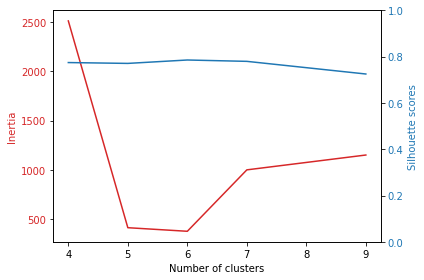

In [16]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(top_results['n_clust'].values, top_results['inertia'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(top_results['n_clust'].values, top_results['silh'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

For DBSCAN the _inertia_ can be misleading, since it is naturally decreased for increasing number of _noise_ samples. The _fraction of clustered samples_ is probably more interesting in this case.

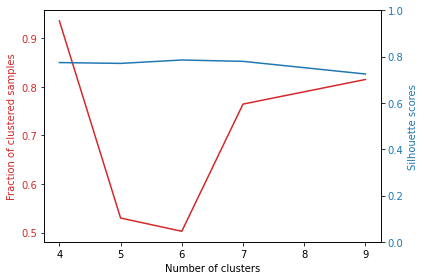

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Fraction of clustered samples', color=color)
ax1.plot(top_results['n_clust'].values, top_results['clust_f'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(top_results['n_clust'].values, top_results['silh'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Additional insights can be obtained by the `heatmaps`, which allow to observe the results of pairs of parameters.

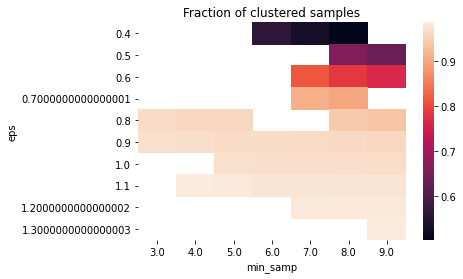

In [18]:
results_pivot =results.pivot('eps', 'min_samp', 'clust_f')
plt.title("Fraction of clustered samples")
ax = sns.heatmap(results_pivot)

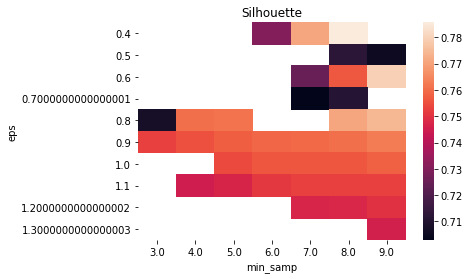

In [19]:
import seaborn as sns
results_pivot =results.pivot('eps', 'min_samp', 'silh')
plt.title("Silhouette")
ax = sns.heatmap(results_pivot)

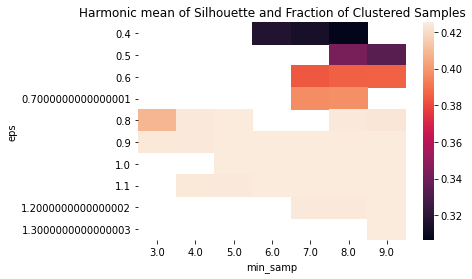

In [20]:
results_pivot =results.pivot('eps', 'min_samp', 'sc_index')
plt.title("Harmonic mean of Silhouette and Fraction of Clustered Samples")
ax = sns.heatmap(results_pivot)

## 5. Show the best value for the parameter(s)

In [21]:
# find the row with the best results according to
# sc_index
best = results.iloc[results.index.argmax()]

In [22]:
print("Best tradeoff between Silhouette and Fraction of Clustered")
print("EPS = {:3.2f}\tMIN_SAMPLES = {:2.0f}".format(best.eps, best.min_samp))
print("Results with best parameters")
print("Silhouette = {:3.2f}\tClustered Fraction = {:3.2f}\tNumber of Clusters = {:2.0f}".\
      format(best.silh, best.clust_f,best.n_clust))

Best tradeoff between Silhouette and Fraction of Clustered
EPS = 1.30	MIN_SAMPLES =  9
Results with best parameters
Silhouette = 0.75	Clustered Fraction = 0.99	Number of Clusters =  4


## 6. Cluster with the optimal parameter(s) and show the pairplot

In [23]:
db = DBSCAN(eps=best.eps, min_samples=int(best.min_samp))
y_db = db.fit_predict(X)

In [24]:
df['cluster'] = y_db

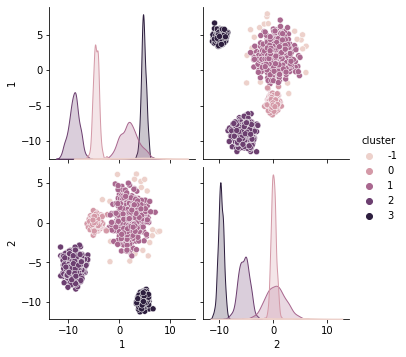

In [25]:
sns.pairplot(df[int_cols + ['cluster']], vars = df[int_cols], hue = 'cluster')

In [26]:
# plot_clusters(X,y_db,dim=(int_cols[0],int_cols[1]), points = cluster_centers)

## 7. Quantifying the quality of clustering  via silhouette plots
The silhouette scores for the individual samples are computed with the function `silhouette_samples`

The function `plot_silhouette` produces a 'horizontal bar-plot', with one bar for each sample, where the length of the bar is proportional to the silhouette score of the sample. The bars are grouped for cluster and sorted for decreasing length. 

A vertical line represents the silhouette score, i.e. the average on all the samples.

In [27]:
# from plot_silhouette import plot_silhouette
from plot_silhouette2 import plot_silhouette

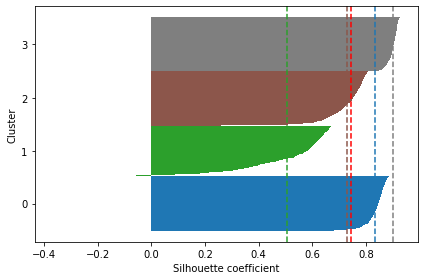

In [28]:
X_cl = X[y_db!=-1,:]
y_db_cl = y_db[y_db!=-1]
silhouette = silhouette_samples(X_cl,y_db_cl)
plot_silhouette(silhouette,y_db_cl)
# silhouette = silhouette_samples(X,y_db)
# plot_silhouette(silhouette,y_db)

## 8. Sorted list of the discovered clusters for decreasing sizes (7pt)

There are several ways to perform this task. 

`groupby().size()` returns a dataframe, resetting the index we can name the newly created column with the counts. Then we can sort the values in descending order.

In [29]:
counts = pd.DataFrame(y_db).groupby(0).size().reset_index(name='Count')
counts = counts.rename(columns = {0: 'Cluster'}).sort_values(by = 'Count', ascending = False)
counts

,Cluster,Count
1,0,378
3,2,375
4,3,375
2,1,352
0,-1,20


A better solution uses the `value_counts()` method, which counts the values in the with the same label and sorts the results in descending order.

In [30]:
labels = pd.DataFrame(y_db)
counts = pd.DataFrame(labels.value_counts(), columns=['Count']).reset_index()
counts = counts.rename(columns = {0: 'Cluster'})
counts

,Cluster,Count
0,0,378
1,3,375
2,2,375
3,1,352
4,-1,20
